In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from IPython.display import display, Markdown
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud


In [2]:
csv_path = 'dataset/descriptions'
csv_files = [os.path.join(csv_path, f) for f in os.listdir(csv_path) if f.endswith('.csv')]
dfs = [pd.read_csv(csv_file) for csv_file in csv_files]

combined_df = pd.concat(dfs, ignore_index=True)

**TOTAL # of Images** = 7,246

**TOTAL # of References** = 17,568

**MAX # of References to single image** = 78

**Mean # of References to single image** = 2.425

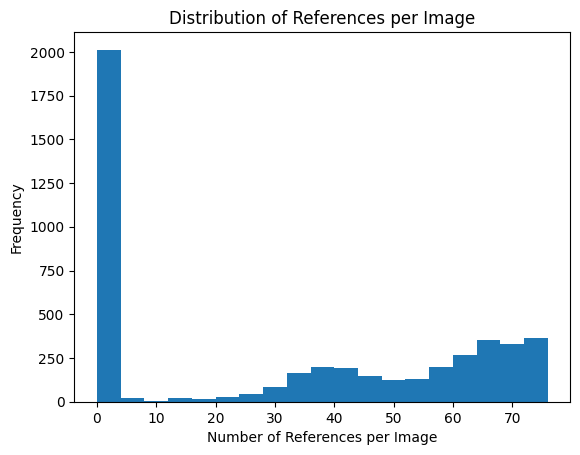

In [3]:
total_references = sum(len(eval(ref)) for ref in combined_df['Reference'])
max_references = max(len(eval(ref)) for ref in combined_df['Reference'])
mean_references = np.mean([len(eval(ref)) for ref in combined_df['Reference']])
n_images = len(combined_df)

display(Markdown(f"**TOTAL # of Images** = {n_images:,}"))
display(Markdown(f"**TOTAL # of References** = {total_references:,}"))
display(Markdown(f"**MAX # of References to single image** = {max_references:,}"))
display(Markdown(f"**Mean # of References to single image** = {mean_references:,.3f}"))


num_refs_per_image = [len(ref) for ref in combined_df['Reference']]
plt.hist(num_refs_per_image, bins=range(0, 80, 4))
plt.xlabel('Number of References per Image')
plt.ylabel('Frequency')
plt.title('Distribution of References per Image')
# Save the figure
plt.savefig('references_per_image_distribution.png', dpi=300)
plt.show()

**TOTAL # of Words** = 241,270

**TOTAL # Unique Words** = 9,304

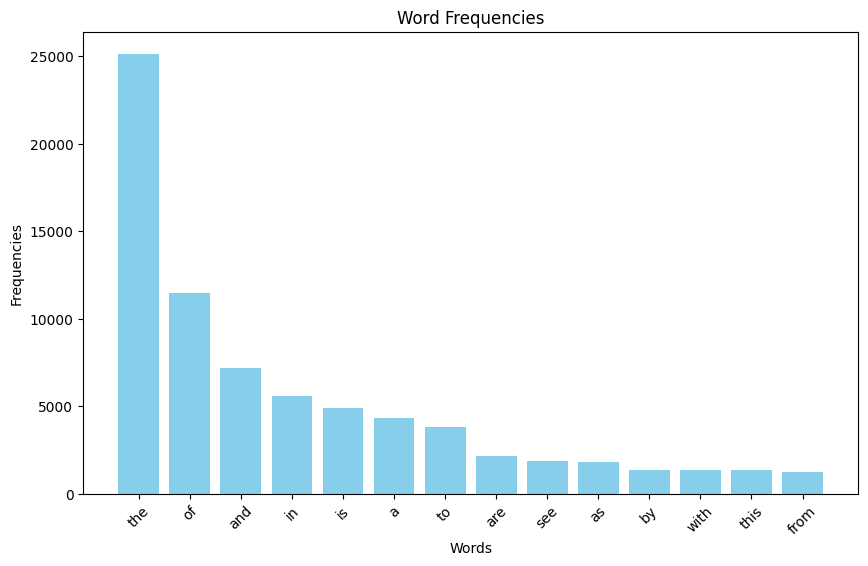

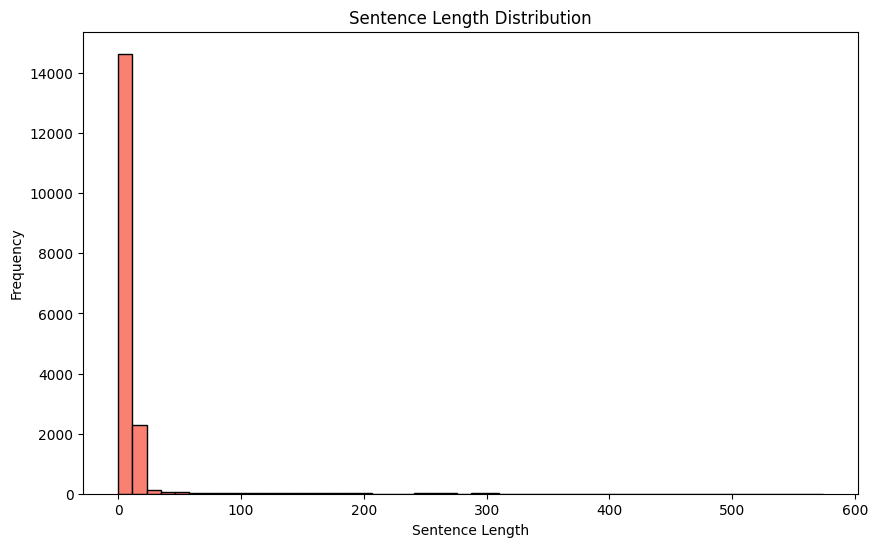

In [4]:
sentences = []
for ref_list in combined_df['Reference']:
    sentences.extend(eval(ref_list))
lowercase_sentences = [str(sentence).lower() for sentence in sentences]
tokenized_sentences = [word_tokenize(sentence) for sentence in lowercase_sentences]

words_only_sentences = [[word for word in sentence if word.isalnum()] for sentence in tokenized_sentences]
all_words = [word for sentence in words_only_sentences for word in sentence]
display(Markdown(f"**TOTAL # of Words** = {len(all_words):,}"))

word_freq = Counter(all_words)
display(Markdown(f"**TOTAL # Unique Words** = {len(word_freq):,}"))

mc_10 = word_freq.most_common(14)


words, frequencies = zip(*mc_10)

sentence_lengths = [len(str(sentence).split()) for sentence in sentences]

fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(words, frequencies, color='skyblue')
ax1.set_xlabel('Words')
ax1.set_ylabel('Frequencies')
ax1.set_title('Word Frequencies')
ax1.tick_params(axis='x', rotation=45)

# Save the Word Frequencies plot
fig1.savefig('word_frequencies.png', dpi=300)

# Plot Sentence Length Distribution
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.hist(sentence_lengths, bins=50, color='salmon', edgecolor='black')
ax2.set_xlabel('Sentence Length')
ax2.set_ylabel('Frequency')
ax2.set_title('Sentence Length Distribution')

# Save the Sentence Length Distribution plot
fig2.savefig('sentence_length_distribution.png', dpi=300)

# Show the plots
plt.show()

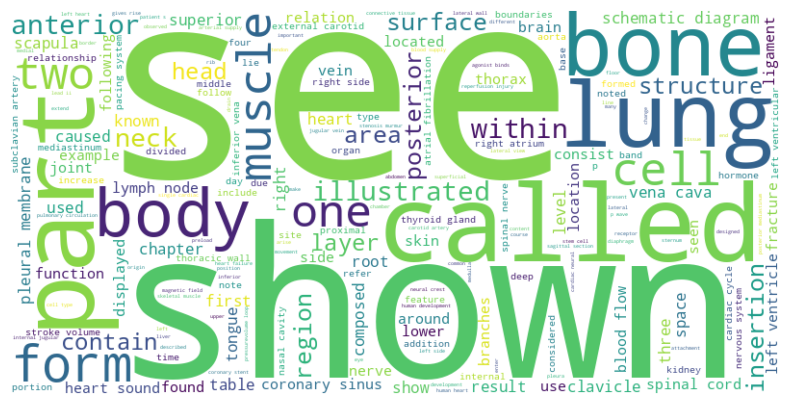

In [5]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('word_cloud.png')
plt.show()

In [6]:
from transformers import AutoTokenizer
t = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = AutoTokenizer.from_pretrained(t)
tokenizer.model_max_length = 77

/home/oguz/Desktop/BIL471/project/pdf_scrapper/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/oguz/Desktop/BIL471/project/pdf_scrapper/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
from MedCLIP.medclip import MedCLIPModel, MedCLIPVisionModelViT, MedCLIPVisionModel
from MedCLIP.medclip import MedCLIPProcessor
from train.dataset import MedClipDataset
from torch.utils.data import DataLoader
from nltk.tokenize import word_tokenize
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.eval()
model.cuda()
dataset = MedClipDataset('dataset/descriptions', 'train', ref_r=1)
dataloader = DataLoader(dataset,
                        batch_size=18, shuffle=False, pin_memory=True, collate_fn=MedClipDataset.collate_fn)
for idx, batch in enumerate(dataloader):
    try:
        outs = model(**batch)
    except:
        t = [len(word_tokenize(s)) for s in batch['original_text']]
        print(t)

/home/oguz/Desktop/BIL471/project/pdf_scrapper/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/oguz/Desktop/BIL471/project/pdf_scrapper/venv/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a B

load model weight from: ./pretrained/medclip-vit


Token indices sequence length is longer than the specified maximum sequence length for this model (171 > 77). Running this sequence through the model will result in indexing errors


[385, 385, 10, 10, 12, 10, 12, 5, 11, 10, 10, 16, 16, 11, 9, 9, 9, 9]
[10, 8, 10, 10, 10, 10, 6, 6, 8, 5, 10, 9, 388, 10, 10, 10, 10, 10]
[124, 124, 11, 6, 11, 11, 298, 298, 298, 298, 11, 464, 10, 8, 4, 4, 6, 10]
[10, 10, 10, 11, 6, 11, 6, 11, 12, 6, 6, 6, 10, 6, 10, 10, 574, 6]
[11, 10, 11, 10, 6, 6, 6, 11, 9, 527, 105, 5, 4, 8, 10, 10, 9, 6]
[47, 5, 11, 6, 6, 29, 44, 16, 13, 60, 60, 60, 11, 13, 37, 12, 12, 321]
[13, 6, 6, 12, 11, 10, 9, 9, 9, 259, 259, 259, 259, 259, 259, 2, 8, 6]
[12, 11, 11, 5, 11, 9, 8, 13, 12, 288, 13, 13, 3, 13, 8, 13, 2, 8]
[248, 248, 6, 7, 8, 10, 2, 12, 4, 6, 6, 6, 308, 308, 308, 308, 8, 308]
[8, 13, 11, 6, 11, 8, 1, 11, 7, 9, 289, 289, 289, 1, 10, 11, 6, 11]
[9, 12, 6, 8, 6, 2, 11, 11, 12, 5, 9, 11, 277, 6, 9, 11, 12, 6]
[7, 11, 11, 6, 266, 266, 4, 10, 1, 1, 266, 266, 10, 9, 266, 6, 6, 10]
[10, 7, 9, 6, 11, 12, 13, 12, 305, 305, 305, 305, 5, 305, 305, 305, 305, 6]


In [8]:
ref_list = [eval(r) for r in dataset.dataset['Reference']]
new_ref_list = []
for l in ref_list:
    current = []
    for sent in l:
        if len(word_tokenize(sent)) <= 128:
            current.append(sent)
    new_ref_list.append(current)
dataset.dataset['Reference'] = new_ref_list

In [9]:
from MedCLIP.medclip import MedCLIPModel, MedCLIPVisionModelViT, MedCLIPVisionModel
from MedCLIP.medclip import MedCLIPProcessor
from train.dataset import MedClipDataset
from torch.utils.data import DataLoader
from nltk.tokenize import word_tokenize
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.eval()
model.cuda()
dataloader = DataLoader(dataset,
                        batch_size=18, shuffle=False, pin_memory=True, collate_fn=MedClipDataset.collate_fn)
for idx, batch in enumerate(dataloader):
    try:
        outs = model(**batch)
    except:
        t = [len(word_tokenize(s)) for s in batch['original_text']]
        print(t)

/home/oguz/Desktop/BIL471/project/pdf_scrapper/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_

load model weight from: ./pretrained/medclip-vit


In [11]:
dataset.dataset['Reference']

0                                                      []
1                                                      []
2                                                      []
3                                                      []
4       [the bundle of His  Refer to  The location is ...
                              ...                        
5543                                                   []
5544                                                   []
5545    [Replaced Prolactin secretion in a nursing mot...
5546    [the opening to the uterus  See  In many cases...
5547                                                   []
Name: Reference, Length: 5548, dtype: object

In [15]:
dataset.dataset.to_csv("DATASET.csv")

In [13]:
csv_path = 'dataset/descriptions'
csv_files = [os.path.join(csv_path, f) for f in os.listdir(csv_path) if f.endswith('.csv')]
dfs = [pd.read_csv(csv_file) for csv_file in csv_files]

combined_df = pd.concat(dfs, ignore_index=True)

In [14]:
combined_df

,Image,Description,Reference,Match,Book,Cleaned_Description,Lemmatized_Description,Stemmed_Description,split
0,dataset/images/20.pdf/page_10_image_1.png,Position of the heart in the thorax,['the heartthe pulmonary and systemic circulat...,Fig. 1,20.pdf,position heart thorax,position heart thorax,posit heart thorax,train
1,dataset/images/20.pdf/page_15_image_1.jpeg,The major paths of blood flow through pulmonar...,['the heartthe pulmonary and systemic circulat...,Fig. 1,20.pdf,major paths blood flow pulmonary systemic circ...,major path blood flow pulmonary systemic circu...,major path blood flow pulmonari system circula...,train
2,dataset/images/20.pdf/page_16_image_1.jpeg,The microcirculation including arterioles capi...,['arterioles capillaries and venules Impo...,Fig. 2,20.pdf,microcirculation including arterioles capillar...,microcirculation including arteriole capillary...,microcircul includ arteriol capillari venul ca...,train
3,dataset/images/20.pdf/page_17_image_1.jpeg,Contractions of the skeletal muscles aid in re...,"['', 'of blood volume to the heart The pulm...",Fig. 3,20.pdf,contractions skeletal muscles aid returning bl...,contraction skeletal muscle aid returning bloo...,contract skelet muscl aid return blood heart t...,train
4,dataset/images/20.pdf/page_18_image_1.png,Pathway of blood flow through the heart and lu...,"['', 'chambers of the heart is indicated in R...",Fig. 4,20.pdf,pathway blood flow heart lungs note pulmonary ...,pathway blood flow heart lung note pulmonary a...,pathway blood flow heart lung note pulmonari a...,train
...,...,...,...,...,...,...,...,...,...
7241,dataset/images/12.pdf/page_1118_image_1.jpeg,Childbirth a crowning b expulsion c delivery o...,[],FIGURE 16.24,12.pdf,childbirth crowning b expulsion c delivery pla...,childbirth crowning b expulsion c delivery pla...,childbirth crown b expuls c deliveri placenta,train
7242,dataset/images/12.pdf/page_1120_image_1.jpeg,Prolactin secretion in a nursing mother,['Replaced Prolactin secretion in a nursing mo...,FIGURE 16.25,12.pdf,prolactin secretion nursing mother,prolactin secretion nursing mother,prolactin secret nurs mother,train
7243,dataset/images/12.pdf/page_1122_image_1.jpeg,Ectopic pregnancy a ectopic pregnancy within t...,"['Replaced Ectopic pregnancy photo part b', '...",FIGURE 16.26,12.pdf,ectopic pregnancy ectopic pregnancy within ute...,ectopic pregnancy ectopic pregnancy within ute...,ectop pregnanc ectop pregnanc within uterin tu...,test
7244,dataset/images/12.pdf/page_1123_image_1.jpeg,Placenta previa,['the opening to the uterus See In many case...,FIGURE 16.27,12.pdf,placenta previa,placenta previa,placenta previa,train


In [15]:
ref_list = [eval(r) for r in combined_df['Reference']]
new_ref_list = []
for l in ref_list:
    current = []
    for sent in l:
        if sent == '':
            continue
        if len(word_tokenize(sent)) <= 128:
            current.append(sent)
    new_ref_list.append(current)
combined_df['Reference'] = new_ref_list

In [19]:
import pandas as pd

In [21]:
data = pd.read_csv('DATASET.csv')

In [23]:
import os
data = data[data['Image'].apply(lambda x:os.path.isfile(x))].reset_index().drop(columns=['index'])

In [25]:
data.to_csv('DATASET2.csv')